# **PART I: Neural Recommender System** #

# Step 1: Loading and Exploring the Dataset

In [31]:
import pandas as pd
import os.path as op
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# Download and extract the dataset
ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = "Downloads/ml-100k.zip"  # Store ZIP file in 'Downloads' folder
ML_100K_FOLDER = "Downloads/ml-100k"        # Extract inside 'Downloads' folder


if not op.exists(ML_100K_FILENAME):
    print(f'Downloading:\t {ML_100K_URL} --> {ML_100K_FILENAME}')
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)
else:
    print(f'Already downloaded:\t {ML_100K_URL} --> {ML_100K_FILENAME}')


if not op.exists(ML_100K_FOLDER):
    print(f'Extracting:\t {ML_100K_FILENAME} --> {ML_100K_FOLDER}')
    ZipFile(ML_100K_FILENAME).extractall("Downloads/")
else:
    print(f'Already extracted:\t {ML_100K_FILENAME} --> {ML_100K_FOLDER}')

Already downloaded:	 http://files.grouplens.org/datasets/movielens/ml-100k.zip --> Downloads/ml-100k.zip
Already extracted:	 Downloads/ml-100k.zip --> Downloads/ml-100k


## Step 1.1: See the Content of the Downloaded Files

In [104]:
# Load ratings
raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t', names=["user_id", "item_id", "rating", "timestamp"])

# Load item metadata
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|', names=m_cols, usecols=range(5), encoding='latin-1')

# Display first few rows
print("Ratings DataFrame:")
print(raw_ratings.head())
print("\nItems DataFrame:")
print(items.head())

Ratings DataFrame:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Items DataFrame:
   item_id              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...  
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...  
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...  
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...  
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)  


# Step 2: Preprocessing the Data

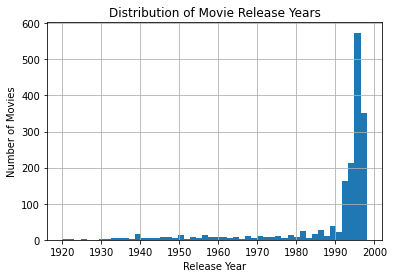

In [33]:
from sklearn.model_selection import train_test_split

# Extract release year from release_date
def extract_year(release_date):
    if isinstance(release_date, str):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    return 1920  # Default for missing values

items['release_year'] = items['release_date'].map(extract_year)

# Visualize release year distribution
items.hist('release_year', bins=50)
plt.title("Distribution of Movie Release Years")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.show()

## Step 2.1: See the Content of the DataFrame

In [29]:
# Merge ratings with items
all_ratings = pd.merge(items, raw_ratings, on='item_id')
print("Merged DataFrame (first 5 rows):\n", all_ratings.head())

# Get max user and item IDs
max_user_id = all_ratings['user_id'].max()
max_item_id = all_ratings['item_id'].max()
print(f"\n\n\nMax user ID:\n {max_user_id}, Max item ID: {max_item_id}")

# Rating statistics
print("\n\n\nRating Statistics:\n", all_ratings['rating'].describe())

# Calculate movie popularity
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items, on='item_id')
print("\n\n\nTop 10 Most Popular Movies:\n", items.nlargest(10, 'popularity')[['title', 'popularity']].to_string(index=False))


# Enrich ratings with popularity
all_ratings = pd.merge(popularity, all_ratings, on='item_id')

# Split into train and test sets
ratings_train, ratings_test = train_test_split(all_ratings, test_size=0.2, random_state=0)

# Extract features for training and testing
user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']




Merged DataFrame (first 5 rows):
    item_id  popularity_x  popularity_y  popularity_x  popularity_y  \
0        1           452           452           452           452   
1        1           452           452           452           452   
2        1           452           452           452           452   
3        1           452           452           452           452   
4        1           452           452           452           452   

   popularity_x  popularity_y  popularity_x  popularity_y  popularity_x  ...  \
0           452           452           452           452           452  ...   
1           452           452           452           452           452  ...   
2           452           452           452           452           452  ...   
3           452           452           452           452           452  ...   
4           452           452           452           452           452  ...   

   popularity_x  popularity_y             title  release_date

# Step 3: Building a Simple Embedding Model

In [34]:
from keras.layers import Input, Embedding, Flatten, Dot
from keras.models import Model

# Define inputs
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

# Embedding layers
embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1, input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1, input_length=1, name='item_embedding')(item_id_input)

# Flatten embeddings
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# Dot product
y = Dot(axes=1)([user_vecs, item_vecs])

# Build and compile model
model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

# Initial predictions
initial_train_preds = model.predict([user_id_train, item_id_train])
print("Shape of initial predictions:", initial_train_preds.shape)

Shape of initial predictions: (80000, 1)


# Step 4: Evaluating the Untrained Model

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Compute errors
squared_differences = np.square(initial_train_preds[:, 0] - rating_train.values)
absolute_differences = np.abs(initial_train_preds[:, 0] - rating_train.values)

print("Random init MSE: %.3f" % np.mean(squared_differences))
print("Random init MAE: %.3f" % np.mean(absolute_differences))

# Verify with scikit-learn
print("Random init MSE (sklearn): %.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE (sklearn): %.3f" % mean_absolute_error(initial_train_preds, rating_train))

Random init MSE: 13.719
Random init MAE: 3.529
Random init MSE (sklearn): 13.719
Random init MAE (sklearn): 3.529


# Step 5: Training the Model

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 1s 12us/step - loss: 2.9060 - val_loss: 1.3352
Epoch 2/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.9679 - val_loss: 0.8337
Epoch 3/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.7798 - val_loss: 0.7807
Epoch 4/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.7469 - val_loss: 0.7662
Epoch 5/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.7336 - val_loss: 0.7582
Epoch 6/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.7238 - val_loss: 0.7570


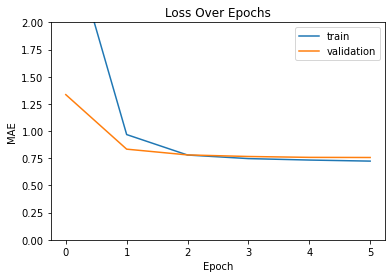

Final test MSE: 0.944
Final test MAE: 0.746
Final train MSE: 0.858
Final train MAE: 0.706


In [38]:
# Train the model
history = model.fit([user_id_train, item_id_train], rating_train, batch_size=64, epochs=6, validation_split=0.1, shuffle=True)

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

# Evaluate on test set
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %.3f" % mean_absolute_error(test_preds, rating_test))

# Evaluate on training set
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %.3f" % mean_absolute_error(train_preds, rating_train))

# Step 6: Building a Deep Recommender Model

Train on 64000 samples, validate on 16000 samples
Epoch 1/5
64000/64000 [==============================] - 1s 20us/step - loss: 1.0212 - val_loss: 0.7586
Epoch 2/5
64000/64000 [==============================] - 1s 16us/step - loss: 0.7544 - val_loss: 0.7487
Epoch 3/5
64000/64000 [==============================] - 1s 17us/step - loss: 0.7409 - val_loss: 0.7408
Epoch 4/5
64000/64000 [==============================] - 1s 17us/step - loss: 0.7314 - val_loss: 0.7387
Epoch 5/5
64000/64000 [==============================] - 1s 18us/step - loss: 0.7231 - val_loss: 0.7331


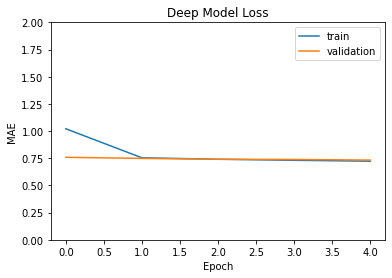

Deep model test MSE: 0.904
Deep model test MAE: 0.731
Deep model train MSE: 0.855
Deep model train MAE: 0.704


In [68]:
from keras.layers import Concatenate, Dense, Dropout

# Define inputs
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

# Embeddings
embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1, input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1, input_length=1, name='item_embedding')(item_id_input)

# Flatten
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# Concatenate and add dense layers
input_vecs = Concatenate()([user_vecs, item_vecs])
input_vecs = Dropout(0.3)(input_vecs)  # Prevent overfitting
x = Dense(64, activation='relu')(input_vecs)
y = Dense(1, activation='linear')(x)

# Build and compile
model_deep = Model(inputs=[user_id_input, item_id_input], outputs=y)
model_deep.compile(optimizer='adam', loss='mae')

# Train
history_deep = model_deep.fit([user_id_train, item_id_train], rating_train, batch_size=64, epochs=5, validation_split=0.2, shuffle=True)

# Plot loss
plt.plot(history_deep.history['loss'], label='train')
plt.plot(history_deep.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Deep Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

# Evaluate
test_preds_deep = model_deep.predict([user_id_test, item_id_test])
print("Deep model test MSE: %.3f" % mean_squared_error(test_preds_deep, rating_test))
print("Deep model test MAE: %.3f" % mean_absolute_error(test_preds_deep, rating_test))

train_preds_deep = model_deep.predict([user_id_train, item_id_train])
print("Deep model train MSE: %0.3f" % mean_squared_error(train_preds_deep, rating_train))
print("Deep model train MAE: %0.3f" % mean_absolute_error(train_preds_deep, rating_train))

# Step 7: Retrieving Embeddings

In [74]:
weights = model.get_weights()
print("\n\nWeights:\n", [w.shape for w in weights])
print("\n\nSummary:\n", model.summary())

weights_deep = model_deep.get_weights()
print("\n\nWeights Deep:\n", [w.shape for w in weights_deep])
print("\n\nSummary Deep:\n", model_deep.summary())



Weights:
 [(944, 30), (1683, 30)]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 30)        28320       user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 30)        50490       item[0][0]                       
________________________________________________________

## Step 7.1: Printing Embeddings

In [75]:
# weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]
print("Model Metadata:")
print("\nFirst item name from metadata:", items["title"][1])
print("\nEmbedding vector for the first item:", item_embeddings[1])
print("\nShape:", item_embeddings[1].shape)


# weights_deep = model_deep.get_weights()
user_embeddings = weights_deep[0]
item_embeddings = weights_deep[1]
print("\n\n\nDeep Metadata:")
print("\nFirst item name from metadata:", items["title"][1])
print("\nEmbedding vector for the first item:", item_embeddings[1])
print("\nShape:", item_embeddings[1].shape)

Model Metadata:

First item name from metadata: GoldenEye (1995)

Embedding vector for the first item: [ 0.40579337 -0.30207893  0.49330223  0.36282426 -0.38556132 -0.42900118
  0.3117383  -0.17753382  0.40745515  0.34297198  0.41671932  0.43302098
  0.13501869 -0.42772692  0.29819128  0.49644154 -0.40771386 -0.1791847
  0.46554488  0.39528978 -0.30394742 -0.33464402  0.52377594 -0.44524828
 -0.34439015  0.4369193   0.40687737 -0.46202448  0.36345637 -0.3344185 ]

Shape: (30,)



Deep Metadata:

First item name from metadata: GoldenEye (1995)

Embedding vector for the first item: [ 0.03618247 -0.04049069  0.06519131 -0.02512775 -0.05403529 -0.10905892
  0.09398577  0.07256597 -0.0497587  -0.01359504 -0.02572505  0.0375342
 -0.01605813  0.12009179 -0.0590348   0.07065597  0.06775748 -0.08167093
  0.00790491 -0.1073471  -0.06624372  0.0634551   0.03333774  0.00255696
 -0.03956097  0.07754119 -0.03827654 -0.01609962 -0.10258127 -0.06660575]

Shape: (30,)


## Step 7.2: cosine(), cosine_similarities(), euclidean_distances(), most_similar()

In [114]:
def cosine(x, y):
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    return np.dot(x, y)

def cosine_similarities(x):
    # TODO
    pass

def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

def most_similar(idx, top_n=10, mode='euclidean'):
    if mode == 'euclidean':
        dists = euclidean_distances(item_embeddings[idx])
    else:
        dists = -np.array([cosine(item_embeddings[idx], emb) for emb in item_embeddings])
    top_indices = np.argsort(dists)[1:top_n+1]  # Exclude self
    return [(items.iloc[i]['title'], dists[i]) for i in top_indices]


# Retrieve movie titles for the given IDs
movie_181 = items.loc[items['item_id'] == 181, 'title'].values[0]

# most similar
print(f"\nMovies similar to {movie_181}:\n", most_similar(181))

# sanity checks
print(f"\ncosine of item 1 and item 1:\n {cosine(item_embeddings[1], item_embeddings[1]):0.3f}")

# euclidean distances
euc_dists = euclidean_distances(item_embeddings[1])
print("\neuclidean_distances shape:\n", euc_dists.shape)
print("\neuclidean_distances dictionary:\n", euc_dists[1:5])

# Display most similar movies with proper formatting
print(f"\nMovies similar to {movie_181}:")
for title, dist in most_similar(181, mode="euclidean"):
    print(f"{title:<40}: {dist:.3f}")


Movies similar to Return of the Jedi (1983):
 [('Wild Bunch, The (1969)', 0.18174142), ('12 Angry Men (1957)', 0.1918594), ('Paris, Texas (1984)', 0.19505014), ('Party Girl (1995)', 0.20233755), ('Chasing Amy (1997)', 0.20546404), ('Jungle2Jungle (1997)', 0.20969862), ('Kama Sutra: A Tale of Love (1996)', 0.2123398), ('Lawrence of Arabia (1962)', 0.21512897), ('Touch of Evil (1958)', 0.21594204), ('Restoration (1995)', 0.21608566)]

cosine of item 1 and item 1:
 1.000

euclidean_distances shape:
 (1683,)

euclidean_distances dictionary:
 [0.         0.37747312 0.5034007  0.27449214]

Movies similar to Return of the Jedi (1983):
Wild Bunch, The (1969)                  : 0.182
12 Angry Men (1957)                     : 0.192
Paris, Texas (1984)                     : 0.195
Party Girl (1995)                       : 0.202
Chasing Amy (1997)                      : 0.205
Jungle2Jungle (1997)                    : 0.210
Kama Sutra: A Tale of Love (1996)       : 0.212
Lawrence of Arabia (1962)  

## Step 7.3: Visualizing Embeddings

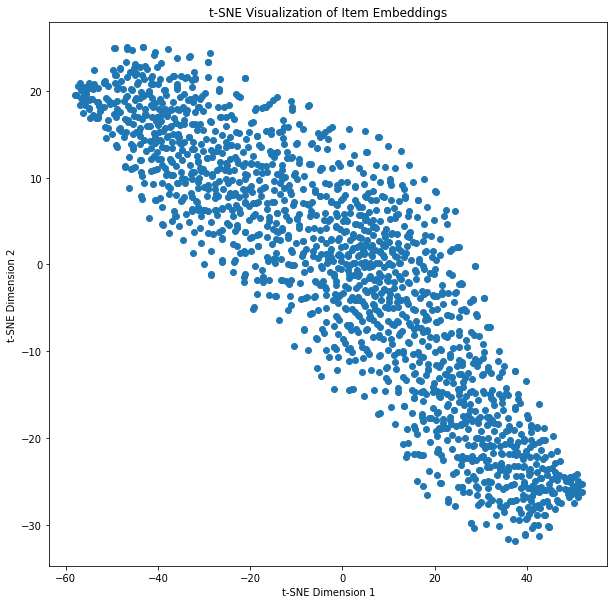

In [115]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1])
plt.title("t-SNE Visualization of Item Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Step 8: Making Recommendations

In [117]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id + 1)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = [i for i in item_ids if i not in seen_movies]

    print(f"\nUser {user_id} has seen {len(seen_movies)} movies, including:")
    for title in all_ratings[seen_mask].nlargest(5, 'popularity')['title']:
        print(f"   {title}")
    print(f"\nComputing ratings for {len(item_ids)} other movies:")

    user_ids = np.full(len(item_ids), user_id)
    rating_preds = model_deep.predict([user_ids, np.array(item_ids)])

    item_preds = list(zip(item_ids, rating_preds[:, 0]))
    item_preds.sort(key=lambda x: x[1], reverse=True)
    rec_items = item_preds[:top_n]
    return [(items.iloc[i-1]['title'], pred) for i, pred in rec_items]  # Adjust for 0-based indexing

# Recommend for user 5
print("\nRecommendations for user 5:")
for title, pred_rating in recommend(5):
    print(f"    {pred_rating:.1f}: {title}")


Recommendations for user 5:

User 5 has seen 175 movies, including:
   Star Wars (1977)
   Fargo (1996)
   Return of the Jedi (1983)
   Toy Story (1995)
   Independence Day (ID4) (1996)

Computing ratings for 1507 other movies:
    4.0: Schindler's List (1993)
    4.0: Usual Suspects, The (1995)
    4.0: Casablanca (1942)
    3.9: Titanic (1997)
    3.9: Godfather: Part II, The (1974)
    3.9: Rear Window (1954)
    3.9: Shawshank Redemption, The (1994)
    3.9: Godfather, The (1972)
    3.9: Raise the Red Lantern (1991)
    3.9: To Live (Huozhe) (1994)


# **PART II: Embeddings with Keras** #

# Step 1: Import Libraries and Create Embedding Matrix

In [1]:
import numpy as np

embedding_size = 4
vocab_size = 10

# Create the embedding matrix
embedding_matrix = np.arange(embedding_size * vocab_size, dtype='float32')
embedding_matrix = embedding_matrix.reshape(vocab_size, embedding_size)
print("\nEmbedding Matrix:\n", embedding_matrix)

# Example index to fetch an embedding
i = 3
print(f"\nEmbedding vector for index {i}:\n", embedding_matrix[i])


Embedding Matrix:
 [[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]
 [16. 17. 18. 19.]
 [20. 21. 22. 23.]
 [24. 25. 26. 27.]
 [28. 29. 30. 31.]
 [32. 33. 34. 35.]
 [36. 37. 38. 39.]]

Embedding vector for index 3:
 [12. 13. 14. 15.]


# Step 2: Define One-Hot Encoding and Calculate the Embedding Vector

In [2]:
def onehot_encode(dim, label):
    return np.eye(dim)[label]

# One-hot encode for the given index
onehot_i = onehot_encode(vocab_size, i)
print(f"\nOne-hot encoded vector for index {i}:\n", onehot_i)

# Compute the embedding vector by multiplying one-hot vector with the embedding matrix
embedding_vector = np.dot(onehot_i, embedding_matrix)
print(f"\nEmbedding vector for index {i}:\n", embedding_vector)


One-hot encoded vector for index 3:
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

Embedding vector for index 3:
 [12. 13. 14. 15.]


# Step 3: Create the Keras Embedding Layer

In [6]:
from keras.layers import Embedding
from keras.layers import Input
from keras.models import Model

# Define the embedding layer
embedding_layer = Embedding(output_dim=embedding_size, input_dim=vocab_size, weights=[embedding_matrix], input_length=1, name='my_embedding')

# Set up the Keras model using the embedding layer
x = Input(shape=[1], name='input')
embedding = embedding_layer(x)
model = Model(inputs=x, outputs=embedding)

# Print the output shape of the model
print(f"\nModel output shape:\n {model.output_shape}")

# Print model weights (embedding weights)
print(f"\nModel weights:\n", model.get_weights())

# Print model summary to show trainable parameters
print(f"\nModel summary:\n", model.summary())


Model output shape:
 (None, 1, 4)

Model weights:
 [array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.],
       [16., 17., 18., 19.],
       [20., 21., 22., 23.],
       [24., 25., 26., 27.],
       [28., 29., 30., 31.],
       [32., 33., 34., 35.],
       [36., 37., 38., 39.]], dtype=float32)]
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
my_embedding (Embedding)     (None, 1, 4)              40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________

Model summary:
 None


# Step 4: Make Predictions with the Keras Embedding Model

In [7]:
# Example of projecting integer labels into their matching embedding vectors

labels_to_encode = np.array([[3]])
print(f"\nPrediction for label 3:\n", model.predict(labels_to_encode))

labels_to_encode = np.array([[3], [3], [0], [9]])
print(f"\nPredictions for labels [3, 3, 0, 9]:\n", model.predict(labels_to_encode))


Prediction for label 3:
 [[[12. 13. 14. 15.]]]

Predictions for labels [3, 3, 0, 9]:
 [[[12. 13. 14. 15.]]

 [[12. 13. 14. 15.]]

 [[ 0.  1.  2.  3.]]

 [[36. 37. 38. 39.]]]


# Step 5: Flatten the Output of the Embedding Layer

In [8]:
from keras.layers import Flatten

# Modify the model to flatten the output (removing the sequence dimension)
y = Flatten()(embedding_layer(x))
model2 = Model(inputs=x, outputs=y)

# Print the output shape of the new model
print(f"\nNew model output shape after flattening:\n {model2.output_shape}")

# Test the flattened model with a sample input
print(f"\nPrediction for label 3 after flattening:\n", model2.predict(np.array([3])))


New model output shape after flattening:
 (None, 4)

Prediction for label 3 after flattening:
 [[12. 13. 14. 15.]]
